# Predicting English word version of numbers using an RNN

To begin learning about **Recurrent Neural Networks** we will build an RNN to predict the English word version of numbers. 

Let's predict what should come next in this sequence: 
*eight thousand one, eight thousand two, eight thousand three, eight thousand four, ...* 

### In deep learning, there are 2 types of numbers
**Parameters** are numbers that are learned. **Activations** are numbers that are calculated (by affine functions & element-wise non-linearities).

When you learn about any new concept in deep learning, ask yourself: is this a parameter or an activation?

# Data

In [31]:
# Making sure our GPU is setup
import torch

print(torch.cuda.device_count())
device = torch.cuda.current_device()

# printing device name
print(torch.cuda.get_device_name(device))

# setting the device
torch.cuda.set_device(device)

1
GeForce RTX 2070 with Max-Q Design


In [3]:
from fastai.text import *

In [32]:
bs=64

In [33]:
path = untar_data(URLs.HUMAN_NUMBERS)
path.ls()

[WindowsPath('C:/Users/dmber/.fastai/data/human_numbers/train.txt'),
 WindowsPath('C:/Users/dmber/.fastai/data/human_numbers/valid.txt')]

In [34]:
def readnums(d): return [', '.join(o.strip() for o in open(path/d).readlines())]

In [35]:
# Checking our train and text
train_text = readnums('train.txt')
train_text[0][:80]

'one, two, three, four, five, six, seven, eight, nine, ten, eleven, twelve, thirt'

In [36]:
# checking our test text
valid_text = readnums('valid.txt')
valid_text[0][-80:]

' nine thousand nine hundred ninety eight, nine thousand nine hundred ninety nine'

In [37]:
# Creating our datasets with FASTAI
train = TextList(train_text, path=path)
valid = TextList(valid_text, path=path)

src = ItemLists(path=path, train=train, valid=valid).label_for_lm()
data = src.databunch(bs=int(bs))

In [38]:
type(train)

fastai.text.data.LMTextList

In [39]:
?LMTextList

Init signature:
LMTextList(
    items: Iterator,
    vocab: fastai.text.transform.Vocab = None,
    pad_idx: int = 1,
    **kwargs,
)
Docstring:      Special `TextList` for a language model.
File:           c:\users\dmber\anaconda3\lib\site-packages\fastai\text\data.py
Type:           type
Subclasses:     


In [40]:
type(src)

fastai.data_block.LabelLists

In [41]:
?LabelLists

Init signature:
LabelLists(
    path: Union[pathlib.Path, str],
    train: fastai.data_block.ItemList,
    valid: fastai.data_block.ItemList,
)
Docstring:      A `LabelList` for each of `train` and `valid` (optional `test`).
File:           c:\users\dmber\anaconda3\lib\site-packages\fastai\data_block.py
Type:           type
Subclasses:     


In [42]:
type(data)

fastai.text.data.TextLMDataBunch

In [43]:
?TextLMDataBunch

Init signature:
TextLMDataBunch(
    train_dl: torch.utils.data.dataloader.DataLoader,
    valid_dl: torch.utils.data.dataloader.DataLoader,
    fix_dl: torch.utils.data.dataloader.DataLoader = None,
    test_dl: Union[torch.utils.data.dataloader.DataLoader, NoneType] = None,
    device: torch.device = None,
    dl_tfms: Union[Collection[Callable], NoneType] = None,
    path: Union[pathlib.Path, str] = '.',
    collate_fn: Callable = <function data_collate at 0x00000207BDE9DF28>,
    no_check: bool = False,
)
Docstring:      Create a `TextDataBunch` suitable for training a language model.
File:           c:\users\dmber\anaconda3\lib\site-packages\fastai\text\data.py
Type:           type
Subclasses:     


In [46]:
# Length of our tokens in our valid set
len(data.valid_ds[0][0].data)

13017

In [49]:
data.valid_ds[0][0].data

array([ 2, 19, 11, 12, ..., 20, 10, 28, 20], dtype=int64)

```bptt``` stands for *back-propogation through time*. This tells us hwo many steps of history we are considering.

this can be considered the lenght of a sequence which in our case is a line.

In [45]:
data.bptt, len(data.valid_dl)

(70, 3)

We have 3 batches in our validation set:

13017 tokens, with about ~70 tokens in about a line of text, and 64 lines of text per batch. 

In [51]:
13017/70/bs

2.905580357142857

We will store each batch in a seperate variable, so we can walk through this to understand better what the RNN does at each step:

In [52]:
it = iter(data.valid_dl)
x1,y1 = next(it)
x2,y2 = next(it)
x3,y3 = next(it)
it.close()

In [58]:
x1.shape

torch.Size([64, 70])

checking the shape confirms that we have 64 rows and 70 columns per batch. this essentially represents 64 lines with 70 tokens in each line.

In [59]:
# Grabbing out vocab - valid
v = data.valid_ds.vocab 

In [63]:
v.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 ',']

In [64]:
v.stoi

defaultdict(int,
            {'xxunk': 0,
             'xxpad': 1,
             'xxbos': 2,
             'xxeos': 3,
             'xxfld': 4,
             'xxmaj': 5,
             'xxup': 6,
             'xxrep': 7,
             'xxwrep': 8,
             ',': 9,
             'hundred': 10,
             'thousand': 11,
             'one': 12,
             'two': 13,
             'three': 14,
             'four': 15,
             'five': 16,
             'six': 17,
             'seven': 18,
             'eight': 19,
             'nine': 20,
             'twenty': 21,
             'thirty': 22,
             'forty': 23,
             'fifty': 24,
             'sixty': 25,
             'seventy': 26,
             'eighty': 27,
             'ninety': 28,
             'ten': 29,
             'eleven': 30,
             'twelve': 31,
             'thirteen': 32,
             'fourteen': 33,
             'fifteen': 34,
             'sixteen': 35,
             'seventeen': 36,
             'eight

In [65]:
# checking the first batch - first example
v.textify(x1[0])

'xxbos eight thousand one , eight thousand two , eight thousand three , eight thousand four , eight thousand five , eight thousand six , eight thousand seven , eight thousand eight , eight thousand nine , eight thousand ten , eight thousand eleven , eight thousand twelve , eight thousand thirteen , eight thousand fourteen , eight thousand fifteen , eight thousand sixteen , eight thousand seventeen , eight'

In [68]:
v.textify(y1[0])

'eight thousand one , eight thousand two , eight thousand three , eight thousand four , eight thousand five , eight thousand six , eight thousand seven , eight thousand eight , eight thousand nine , eight thousand ten , eight thousand eleven , eight thousand twelve , eight thousand thirteen , eight thousand fourteen , eight thousand fifteen , eight thousand sixteen , eight thousand seventeen , eight thousand'

In [70]:
# showing batch
data.show_batch(ds_type=DatasetType.Valid)

idx,text
0,"thousand forty seven , eight thousand forty eight , eight thousand forty nine , eight thousand fifty , eight thousand fifty one , eight thousand fifty two , eight thousand fifty three , eight thousand fifty four , eight thousand fifty five , eight thousand fifty six , eight thousand fifty seven , eight thousand fifty eight , eight thousand fifty nine , eight thousand sixty , eight thousand sixty"
1,"eight , eight thousand eighty nine , eight thousand ninety , eight thousand ninety one , eight thousand ninety two , eight thousand ninety three , eight thousand ninety four , eight thousand ninety five , eight thousand ninety six , eight thousand ninety seven , eight thousand ninety eight , eight thousand ninety nine , eight thousand one hundred , eight thousand one hundred one , eight thousand one"
2,"thousand one hundred twenty four , eight thousand one hundred twenty five , eight thousand one hundred twenty six , eight thousand one hundred twenty seven , eight thousand one hundred twenty eight , eight thousand one hundred twenty nine , eight thousand one hundred thirty , eight thousand one hundred thirty one , eight thousand one hundred thirty two , eight thousand one hundred thirty three , eight thousand"
3,"three , eight thousand one hundred fifty four , eight thousand one hundred fifty five , eight thousand one hundred fifty six , eight thousand one hundred fifty seven , eight thousand one hundred fifty eight , eight thousand one hundred fifty nine , eight thousand one hundred sixty , eight thousand one hundred sixty one , eight thousand one hundred sixty two , eight thousand one hundred sixty three"
4,"thousand one hundred eighty three , eight thousand one hundred eighty four , eight thousand one hundred eighty five , eight thousand one hundred eighty six , eight thousand one hundred eighty seven , eight thousand one hundred eighty eight , eight thousand one hundred eighty nine , eight thousand one hundred ninety , eight thousand one hundred ninety one , eight thousand one hundred ninety two , eight thousand"


# Single Fully Connected Model

In [71]:
data = src.databunch(bs=int(bs), bptt=3)

In [72]:
# getting one batch and checking the shape
x,y = data.one_batch()
x.shape, y.shape

(torch.Size([64, 3]), torch.Size([64, 3]))

In [73]:
nv = len(v.itos); nv

40

In [75]:
nh = 64

In [76]:
def loss4(input, target):
    return F.cross_entropy(input, target[:,-1])

def acc4(input, target):
    return accuracy(input, target[:,-1])

In [78]:
# one line - contains three tokens
x[0]

tensor([13,  9, 14])

In [79]:
v.textify(x[0])

'two , three'

In [80]:
# our input is x
# our target is y

Layer names:

* ```i_h```: input to hidden
* ```h_h```: hidden to hidden
* ```h_o```: hidden to output
* ```bn```: batchnorm

In [93]:
# creating our model
class Model0(nn.Module):
    def __init__(self):
        super().__init__()
        self.i_h = nn.Embedding(nv, nh) # nv vocab length = , nh = embedding size
        self.h_h = nn.Linear(nh, nh)
        self.h_o = nn.Linear(nh, nv)
        self.bn = nn.BatchNorm1d(nh)
        
    def forward(self, x):
        """
        This forward is designed to be fixed for 3 timesteps, in general you will want to actually use a for loop when 'unrolling' the RNN
        """
        h = self.bn(F.relu(self.i_h(x[:,0])))
        
        if x.shape[1] > 1:
            h = h + self.i_h(x[:,1])
            h = self.bn(F.relu(self.h_h(h)))
        if x.shape[1] > 2:
            h = h + self.i_h(x[:,2])
            h = self.bn(F.relu(self.h_h(h)))
            
        return self.h_o(h)

In [82]:
x[:,0]

tensor([13, 13, 10,  9, 18,  9, 11, 11, 13, 19, 16, 23, 24,  9, 12,  9, 13, 14,
        15, 11, 10, 22, 15,  9, 10, 14, 11, 16, 10, 28, 11,  9, 20,  9, 15, 15,
        11, 18, 10, 28, 23, 24,  9, 16, 10, 16, 19, 20, 12, 10, 22, 16, 17, 17,
        17, 11, 24, 10,  9, 15, 16,  9, 18, 11])

In [88]:
x.shape

torch.Size([64, 3])

When we call ```x[:,0]``` we are essentially saying feed me an every row in column 1. We will only reach up to ```x[:,2]``` because we only have **3** tokens per line, which is equal to ```bptt``` which is back-propogation-through-time. 

In [92]:
x.shape[1]

3

## Typical Layer of NN
By looking at our model above you will see:
```python
h = self.bn(F.relu(self.i_h(x[0])))
```
The basic unit of a neural network, which is a single layer of the neural network is compsoed of: 

* ```batch_norm``` : normalizes activations in that specific layer so they don't explode or vanish
* ```relu```: Non-linear activation function. This is usually a ```relu``` in the first layer and hidden layer, but a ```softmax``` in the final layer. 
* ```Linear```: A linear, Affine function on ``[X @ WT + B]``:
    * ```X```: Our raw inputs (normalized in some form)
    * ```WT```: Weights, transposed
    * ```B```: Bias vector

In [112]:
# creating our model object
learn = Learner(data, Model0(), loss_func=loss4, metrics=acc4).to_fp16()

In [100]:
Learner?

Init signature:
Learner(
    data: fastai.basic_data.DataBunch,
    model: torch.nn.modules.module.Module,
    opt_func: Callable = functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99)),
    loss_func: Callable = None,
    metrics: Collection[Callable] = None,
    true_wd: bool = True,
    bn_wd: bool = True,
    wd: Union[float, Collection[float]] = 0.01,
    train_bn: bool = True,
    path: str = None,
    model_dir: Union[pathlib.Path, str] = 'models',
    callback_fns: Collection[Callable] = None,
    callbacks: Collection[fastai.callback.Callback] = <factory>,
    layer_groups: Collection[torch.nn.modules.module.Module] = None,
    add_time: bool = True,
    silent: bool = None,
) -> None
Docstring:      Trainer for `model` using `data` to minimize `loss_func` with optimizer `opt_func`.
File:           c:\users\dmber\anaconda3\lib\site-packages\fastai\basic_train.py
Type:           type
Subclasses:     RNNLearner


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


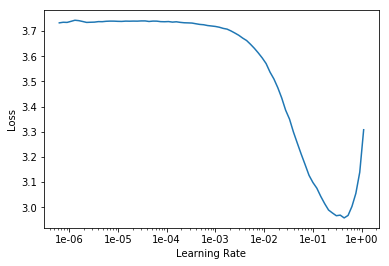

In [108]:
# Training our model
learn.lr_find()
learn.recorder.plot()

In [113]:
# lr = 3e-2
# lr
lr = 1e-4

In [114]:
learn.fit_one_cycle(6, lr)

epoch,train_loss,valid_loss,acc4,time
0,3.595237,3.630497,0.074908,00:03
1,3.014391,3.252281,0.397978,00:03
2,2.451855,2.801948,0.448070,00:03
3,2.150459,2.522917,0.454733,00:03
4,2.030903,2.413841,0.458869,00:03
5,2.005968,2.397740,0.458869,00:03


In [115]:
torch.cuda.empty_cache()

## Model1 With Loop
Now we are going to build the same model but with a loop to make it easier

In [116]:
x.device

device(type='cpu')

In [117]:
device

0

In [118]:
print(torch.cuda.get_device_name(device))

GeForce RTX 2070 with Max-Q Design


In [140]:
class Model1(nn.Module):
    def __init__(self):
        super().__init__()
        self.i_h = nn.Embedding(nv, nh) # takes in input sequence of size vocab length, outputs embedding/feature vector
        self.h_h = nn.Linear(nh, nh) # takes embedded feature vector, outputs activations
        self.h_o = nn.Linear(nh, nv) # takes normalized activations and returns back the output sequence of size vocab length
        self.bn = nn.BatchNorm1d(nh) # takes in activation which is of size nh = embedding size
        
    def forward(self, x):
        # initializing
        # x.shape[0] is the batch size - number of sentences
        h = torch.zeros(x.shape[0], nh).to(device=x.device) 
        
        # unrolling
        # x.shape[1] is the number of lines in that sentence
        for i in range(x.shape[1]):
            h = h + self.i_h(x[:, i])
            h = self.bn(F.relu(self.h_h(h)))
        return self.h_o(h)

In [125]:
# x.shape[0] = size of the batch = how many lines
# x.shape[1] = size of the sequence = how many words in the line
# nh = the embedding size = number of numerical real values to represent a given word
    # 'hello' = [0.2, 3, 1.3, ... , 0.3]
x.shape[0], nh, x.shape[1]

(64, 64, 3)

In [ ]:
# x[:, i] - give me all the words in the first column
# This will produce a vector of size: (batch_size, nh)
    # batch_size = x.shape[0]

In [122]:
torch.zeros(x.shape[0], nh).to(device=device)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [123]:
torch.zeros(x.shape[0], nh).to(device=x.device)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [143]:
# creating our second learner
learn = Learner(data, Model1(), loss_func=loss4, metrics=acc4)

In [137]:
learn.model

Model1(
  (i_h): Embedding(40, 64)
  (h_h): Linear(in_features=64, out_features=64, bias=True)
  (h_o): Linear(in_features=64, out_features=40, bias=True)
  (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [144]:
learn.fit_one_cycle(6, 1e-4)

epoch,train_loss,valid_loss,acc4,time
0,3.616723,3.621270,0.039292,00:02
1,3.033068,3.040188,0.415901,00:02
2,2.417100,2.501141,0.455423,00:02
3,2.089819,2.261344,0.464844,00:02
4,1.967350,2.185948,0.465763,00:02
5,1.942357,2.176027,0.465763,00:02


# Multi fully connected model
Before, we were just predicting the last word in a line of text. Given 70 tokens, what is token 71? That approach was throwing away a lot of data. Why not predict token 2 from token 1, then predict token 3, then predict token 4, and so on? 

In [145]:
# changing our time-step to 20
data = src.databunch(bs=int(bs), bptt=20)

In [146]:
x, y = data.one_batch()
x.shape, y.shape

(torch.Size([64, 20]), torch.Size([64, 20]))

So again, in this case the batch size is **64** and the timesteps which was defined with **back-propogration-through-time** is now **20**

for this model we are not changing the complexity of the network (increasing the size in depth or width), we are simply just adding more data into our input

In [151]:
class Model2(nn.Module):
    def __init__(self):
        super().__init__()
        self.i_h = nn.Embedding(nv, nh)
        self.h_h = nn.Linear(nh, nh)
        self.h_o = nn.Linear(nh, nv)
        self.bn = nn.BatchNorm1d(nh)
        
    def forward(self, x):
        # initial hidden
        h = torch.zeros(x.shape[0], nh).to(device=device)
        
        # keeping track of results at each state
        res = []
        
        # forward 
        for i in range(x.shape[1]):
            h = h + self.i_h(x[:,i])
            h = F.relu(self.h_h(h))
            res.append(self.h_o(self.bn(h)))
        
        return torch.stack(res, dim=1)

In [154]:
learn = Learner(data, Model2(), metrics=accuracy)

In [155]:
learn.fit_one_cycle(10, 1e-4, pct_start=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,3.703450,3.705074,0.024290,00:01
1,3.616543,3.604595,0.063352,00:01
2,3.509150,3.504478,0.163423,00:01
3,3.397028,3.412466,0.276918,00:01
4,3.290816,3.335292,0.325923,00:01
5,3.198787,3.277302,0.338281,00:01
6,3.126806,3.239194,0.345455,00:01
7,3.076252,3.218533,0.349858,00:01
8,3.045120,3.210635,0.351776,00:01
9,3.028868,3.209463,0.351918,00:01


Our accuracy is worse now, because we are doing a harder task. When we predict word k (k<70), we have less history to help us then when we were only prediction word 71. 

The solution to this is to **save our history**. As you may have noticed in our forward function, we always re-initiate ```h```. 

To address this issue, let's keep the hidden state from the previous line of text, so wea re not starting over again on each line of text.

In [180]:
class Model3(nn.Module):
    """
    This model is now keeping track of all hidden states after every sentence, which will in fact increase the accuracy of the model
    """
    def __init__(self):
        super().__init__()
        self.i_h = nn.Embedding(nv, nh)
        self.h_h = nn.Linear(nh, nh)
        self.h_o = nn.Linear(nh, nv)
        self.bn = nn.BatchNorm1d(nh)
        self.h = torch.zeros(bs, nh, dtype=torch.half).cuda() 
        
    def forward(self, x):
        res = [] # outputs
        h = self.h # hidden state
        
        for i in range(x.shape[1]):
            h = h + self.i_h(x[:,i])
            h = F.relu(self.h_h(h))
            res.append(self.bn(h))
            
        self.h = h.detach() # avoids keeping copy
        res = torch.stack(res, dim=1) # concatenates sequence of tensors
        res = self.h_o(res)
        
        return res

In [181]:
learn = Learner(data, Model3(), metrics=accuracy).to_fp16()

In [182]:
learn.fit_one_cycle(20, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.549835,3.540303,0.106676,00:01
1,3.211059,2.925416,0.398864,00:01
2,2.564418,2.016008,0.461009,00:01
3,1.993452,1.946665,0.318963,00:01
4,1.697688,1.957172,0.328835,00:01
5,1.522820,1.776082,0.471946,00:01
6,1.387139,1.694529,0.521449,00:01
7,1.245820,1.578009,0.552202,00:01
8,1.089744,1.524006,0.578764,00:01
9,0.953259,1.515239,0.584375,00:01


# nn.RNN
Let's now refactor all the code above to use PyTorch's RNN. This is what you would use in practice.

In [184]:
nv, nh

(40, 64)

In [188]:
bs

64

In [202]:
class Model4(nn.Module):
    def __init__(self):
        super().__init__()
        self.i_h = nn.Embedding(nv, nh)
        self.rnn = nn.RNN(nh, nh, batch_first=True) 
        self.h_o = nn.Linear(nh, nv)
        self.bn = BatchNorm1dFlat(nh)
        self.h = torch.zeros(1, bs, nh, dtype=torch.half).cuda()
        
    def forward(self, x):
        res, h = self.rnn(self.i_h(x), self.h)
        self.h = h.detach()
        return self.h_o(self.bn(res))

In [203]:
??BatchNorm1dFlat

Init signature:
BatchNorm1dFlat(
    num_features,
    eps=1e-05,
    momentum=0.1,
    affine=True,
    track_running_stats=True,
)
Source:        
class BatchNorm1dFlat(nn.BatchNorm1d):
    "`nn.BatchNorm1d`, but first flattens leading dimensions"
    def forward(self, x):
        if x.dim()==2: return super().forward(x)
        *f,l = x.shape
        x = x.contiguous().view(-1,l)
        return super().forward(x).view(*f,l)
File:           c:\users\dmber\anaconda3\lib\site-packages\fastai\layers.py
Type:           type
Subclasses:     


In [204]:
learn = Learner(data, Model4(), metrics=accuracy).to_fp16()

In [205]:
learn.fit_one_cycle(20, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.565941,3.499253,0.084730,00:00
1,3.094652,2.632511,0.450213,00:00
2,2.385264,1.914898,0.406960,00:00
3,1.889531,1.957727,0.331676,00:00
4,1.609220,1.765874,0.471591,00:00
5,1.372195,1.593361,0.503551,00:00
6,1.149054,1.578473,0.533239,00:00
7,0.965053,1.507169,0.561506,00:00
8,0.816868,1.363181,0.600781,00:00
9,0.709663,1.390668,0.606960,00:00


# 2-layer GRU

In [206]:
class Model5(nn.Module):
    def __init__(self):
        super().__init__()
        self.i_h = nn.Embedding(nv, nh)
        self.rnn = nn.GRU(nh, nh, 2, batch_first=True)
        self.h_o = nn.Linear(nh, nv)
        self.bn = BatchNorm1dFlat(nh)
        self.h = torch.zeros(2, bs, nh, dtype=torch.half).cuda()
        
    def forward(self, x):
        res, h = self.rnn(self.i_h(x), self.h)
        self.h = h.detach()
        return self.h_o(self.bn(res))

In [207]:
learn = Learner(data, Model5(), metrics=accuracy).to_fp16()

In [208]:
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.960606,2.324086,0.452770,00:00
1,1.853075,1.473501,0.594460,00:00
2,0.958746,1.042163,0.798011,00:00
3,0.465310,0.924009,0.836151,00:00
4,0.231529,0.978605,0.838210,00:00
5,0.120420,0.944951,0.840696,00:00
6,0.066706,0.971845,0.839276,00:00
7,0.039122,1.004930,0.835867,00:00
8,0.024751,1.027974,0.831960,00:00
9,0.017318,1.014146,0.833026,00:00


## Connected to ULMFiT 
In the previous notebook, we were essentially swapping out ```self.h_o``` with a classifier in order to do classification on text.